In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}

In [ ]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'y',
 24: 'z',
 25: 'ó',
 26: 'ę',
 27: 'ł',
 28: 'ń',
 29: 'ś',
 30: 'ż',
 0: '.'}

In [ ]:
block_size = 3 
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
#building lookup table
C = torch.randn((31,2))

In [ ]:
emb = C[X_train]
emb.shape

torch.Size([3919, 3, 2])

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.rand(100)

In [ ]:
emb = emb.view(-1,6) #matching sizes
h = torch.tanh(emb @ W1 + b1)
h.shape

torch.Size([3919, 100])

In [ ]:
W2 = torch.randn((100, 31))
b2 = torch.randn(31)

logits = h @ W2 + b2
logits.shape

torch.Size([3919, 31])

###softmax


$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

In [ ]:
#softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([3919, 31])


log - the natural log

y - binary indicator (0 or 1) if class label c is the correct classification for observation o

p - predicted probability observation o is of class c


$NLL(y) = -{\log(p(y))}$


In [ ]:
loss = -prob[torch.arange(prob.shape[0]), Y_train].log().mean()
loss

tensor(14.7567)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((31, 10), generator=g) #10D space
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 31), generator=g)
b2 = torch.randn(31, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# will be using F.cross_entropy instead of calculationg it by hand (counts, prob)
loss_2 = F.cross_entropy(logits, Y_train)
loss, loss_2

(tensor(14.7567), tensor(14.7567))

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

12741

In [ ]:
for p in parameters:
  p.requires_grad = True

25.64737892150879
20.933853149414062
21.248937606811523
25.56443214416504
22.495309829711914
23.339366912841797
20.714380264282227
20.575727462768555
25.373504638671875
18.543514251708984
19.767213821411133
19.03477668762207
20.8313045501709
23.704252243041992
15.447561264038086
16.24024200439453
19.608362197875977
15.03000545501709
16.07225799560547
20.558422088623047
16.103538513183594
18.73695182800293
17.42110252380371
15.462782859802246
14.767810821533203
17.05646324157715
15.263886451721191
11.39395523071289
13.50398063659668
15.937312126159668
12.144492149353027
17.116668701171875
13.16891098022461
13.38616943359375
14.048529624938965
13.190545082092285
14.37734317779541
13.559438705444336
14.064979553222656
12.518780708312988
10.853814125061035
15.019464492797852
14.993341445922852
11.054543495178223
10.375520706176758
10.433977127075195
8.966645240783691
11.536076545715332
8.620128631591797
12.306408882141113
9.894858360290527
9.451360702514648
9.680578231811523
10.72836494445

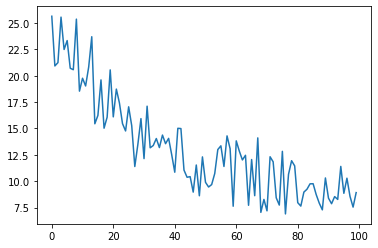

In [ ]:
epochs = 100
losses = []
for _ in range(epochs):
  #creating mini-batch
  ix = torch.randint(0,X_train.shape[0], (32,))
  #forward
  emb = C[X_train[ix]]#(32,3,10)
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)#(32,200)
  logits = h @ W2 + b2#(32,27)
  loss = F.cross_entropy(logits, Y_train[ix])
  print(loss.item())
  losses.append(loss.item())
  #backward
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    p.data += - 0.1 * p.grad
plt.plot(np.arange(epochs), losses)